In [52]:
import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os

In [53]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [54]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [55]:
def generate(a):
    df=pd.read_csv(a).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df=np.array(df)
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:-1])
    df[:,:-1]=transprices.transform(df[:,:-1])
    a=np.max(np.abs(df[:,:-1]))
    b=np.max(np.abs(df[:,-1]))
    df[:,:-1]=df[:,:-1]/a
    df[:,-1]=df[:,-1]/b
    return df,a,b,transprices

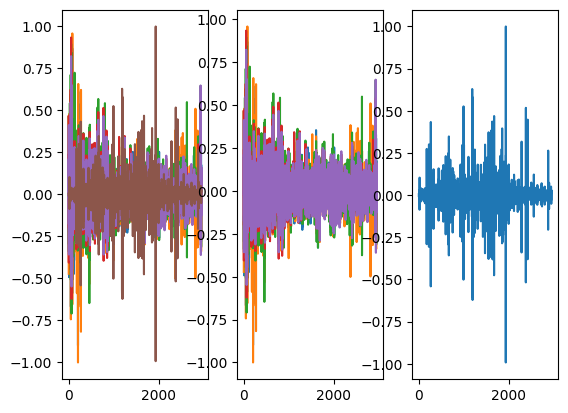

In [56]:
random.shuffle(l1)
random.shuffle(l2)
xx='etfs/'+l2[0]
df,_,__,transa=generate(xx)
fig,ax=plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:-1])
ax[2].plot(df[:,-1])
plt.show()

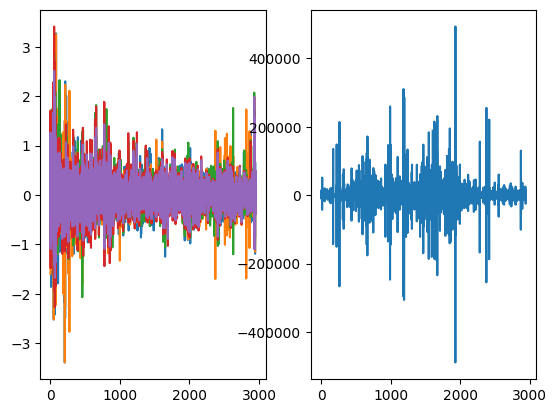

In [57]:
#restoring
def restorePreds(d,_,__,transa):
    df=d.copy()
    df[:,:-1]=transa.inverse_transform(df[:,:-1]*_)
    df[:,-1]=df[:,-1]*__
    return df
df=restorePreds(df,_,__,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:-1])
ax[1].plot(df[:,-1])
plt.show()

In [58]:
def create(dataset,lb,lf=1):
    X,y=[],[]
    for i in range(len(dataset)-lb-lf+1):
        X.append(np.array(dataset[i:i+lb]))
        y.append(np.array(dataset[i+1:i+lb+lf]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [59]:
lb=50
X_train,y_train=create(df,lb=lb)

PHASE 1a1: LSTM PREDICTION

In [60]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=6,hidden_size=100,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(100,20)
        self.l2=nn.Linear(20,6)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        x=self.l2(x)
        return x

In [61]:
model=LSTMModel()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3,step_size_up=10000,mode="triangular2",cycle_momentum=False)

In [62]:
def signloss(y_pred,y):
    return torch.ceil(-y_pred*y)

In [63]:
def lstmloss(y_pred,y):
    return torch.clip(2*torch.mean((torch.square(y_pred-y)*10+signloss(y_pred,y))*torch.cat((torch.abs(y[:,:,:-1]),torch.ones((y.shape[0],50,1)).to('cuda')/50),axis=2)),max=0.1)

In [64]:
def train(n_epochs,dl,lf=1):
    for i in range(n_epochs):
        for X,y in dl:
            y=y.to(device)
            logits=0
            y_pred=model(X.to(device))
            logits+=lstmloss(y_pred,y[:,:lb])
            for j in range(1,lf):
                y_pred=model(y_pred)
                logits+=lstmloss(y_pred,y[:,j:j+lb])
            logits=logits/lf
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [65]:
'''model.train()
for i in l2[:100]:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(1,dl)'''

"model.train()\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(1,dl)"

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [66]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [67]:
'''random.shuffle(l1);random.shuffle(l2)
for i in l2:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=50)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,50)'''

"random.shuffle(l1);random.shuffle(l2)\nfor i in l2:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=50)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,50)"

In [68]:
model.load_state_dict(torch.load('lstmmodel.pt'))

C:\Users\edwin\AppData\Local\Temp\ipykernel_22088\2978307079.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstmmodel.pt'))


<All keys matched successfully>

In [69]:
xx='etfs/'+random.choice(l2)
print(xx)

etfs/PVAL.csv


In [70]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
tester='etfs/'+'IGN.csv'
df,a,b,transprices=generate(xx)
X_test,y_test=create(df,lb=lb)
dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test,y_test),shuffle=False,batch_size=1)
qwer=True
for X,y in dl:
    if qwer:
        ggg=list(X.detach().numpy()[0])
        qwer=False
    ggg.append(model(X.to(device))[0][-1].detach().cpu().numpy())

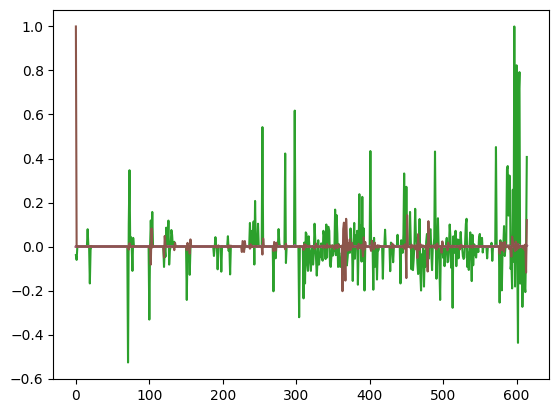

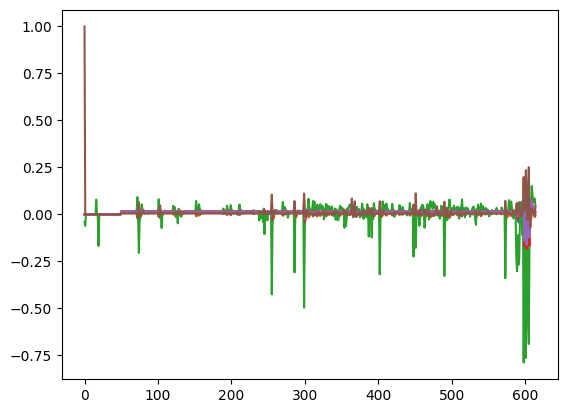

In [71]:
fig,ax=plt.subplots()
ax.plot(df)
fig,ax=plt.subplots()
ax.plot(ggg)

(616, 6)


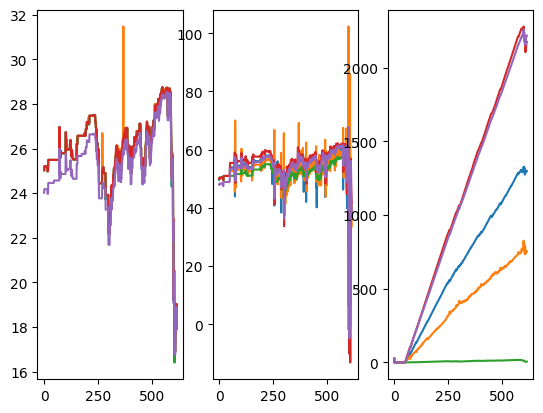

In [72]:
d2=np.array(pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(d2.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(d2[1:,:-1])
ggg=np.array(ggg)
ggg1=restorePreds(ggg,a,b,transprices)
test2=d2[0:-1,:-1]+d2[:-1,:-1]+ggg1[:,:-1]
ax[1].plot(test2[:-1])
testult=[d2[0]]
for i in range(ggg1.shape[0]):
    testult.append(np.sum(ggg1[:i+1],axis=0))
ax[2].plot(np.array(testult)[:-1,:-1])

In [73]:
pp=np.sum(np.ceil(ggg))
pn=np.sum(np.ceil(-ggg))
p=np.sum(np.ceil(df))
n=np.sum(np.ceil(-df))
tp=np.sum(np.ceil(ggg)*np.ceil(df))
tn=np.sum(np.ceil(-ggg)*np.ceil(-df))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.8320802005012531
precision:  0.22140713571190396
acc:  0.49158653846153844
f1:  0.3497498024756387


PHASE 1b1: LGBM

In [74]:
%pip install lightgbm


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [76]:
p_data = pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [78]:
p_data

,Open,High,Low,Close,Adj Close,Volume
0,24.920000,25.030001,24.920000,25.030001,24.016085,120700
1,25.030001,25.030001,25.030001,25.030001,24.016085,0
2,25.200001,25.200001,25.200001,25.200001,24.179199,300
3,25.200001,25.200001,25.200001,25.200001,24.179199,0
4,25.200001,25.200001,25.200001,25.200001,24.179199,0
...,...,...,...,...,...,...
611,17.930000,17.930000,17.930000,17.930000,17.808456,0
612,18.639999,18.639999,18.420000,18.420000,18.295135,1800
613,19.000000,19.030001,19.000000,19.030001,18.901001,700
614,19.030001,19.030001,19.030001,19.030001,18.901001,15000


In [79]:
# Load data
data = d2
X = pd.DataFrame(p_data)
y = pd.Series(p_data.Open)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [80]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [81]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}


In [88]:
# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 25.954620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [89]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


RMSE: 0.5567236942568028
